In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

from sklearn.decomposition import PCA


In [3]:
raw = np.load("/home/andres/data/hbmep-processed/rat/J_RCML_000/mat.npy")
raw = raw[..., [0, 1, 3, 4, 5, 6,]]
raw.shape

(7676, 428, 6)

In [60]:
raw_one = raw[..., :,0]

In [63]:

raw_one = raw_one.transpose()
raw_one = raw_one[150:,:]


In [64]:
raw_one.shape

(278, 7676)

In [65]:
from sklearn.preprocessing import StandardScaler


In [66]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(raw_one)

In [67]:
data_scaled.shape

(278, 7676)

In [68]:
pca = PCA(n_components=6)  # You can choose a different number of components
principal_components = pca.fit_transform(data_scaled)


In [69]:
principal_components.shape

(278, 6)

In [70]:
df.shape

(7676, 44)

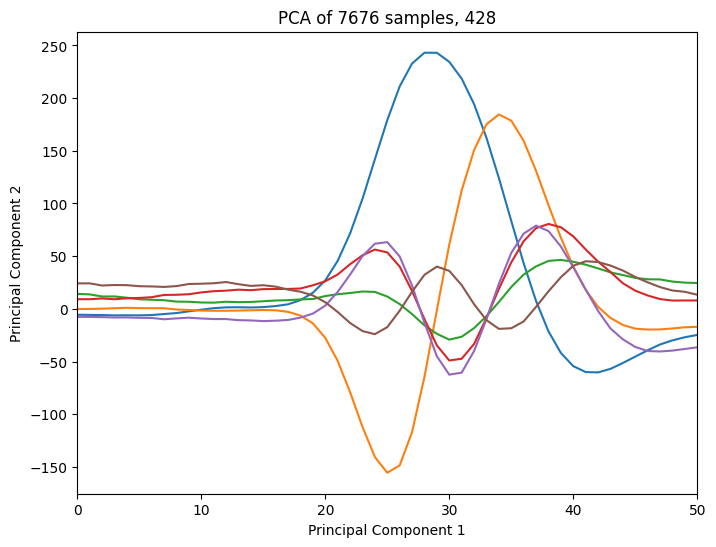

In [74]:
plt.figure(figsize=(8, 6))
for i in range(0, 6):
    plt.plot(np.arange(0, 278), principal_components[:, i])
    plt.title('PCA of 7676 samples, 428')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
plt.xlim(0, 50)
plt.show()

In [32]:
config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)
df = pd.read_csv(DATA_PATH)
df.shape

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(7676, 44)

<Axes: >

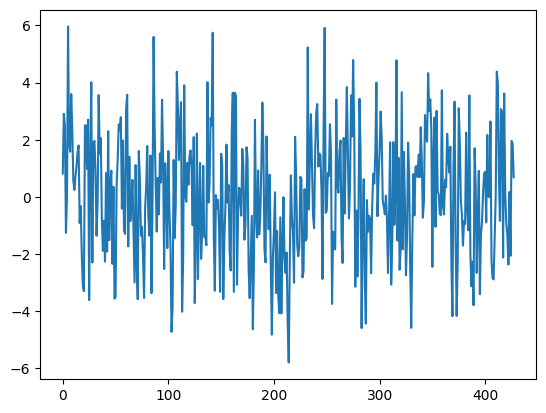

In [23]:
sns.lineplot(y=raw[, :, 0], x=np.arange(428))

In [30]:
combinations = pickle.load(open('/home/andres/repos/rat-mapping-paper/reports/J_RCML_000/combine.pkl', 'rb'))

In [31]:
df['compound_position'].unique()

NameError: name 'df' is not defined

In [5]:
subjects = df["participant"].unique().tolist()
positions = ['L', 'M']
levels = ['C5', 'C6', 'C7', 'C8']
# levels = ['C5-C6', 'C6-C7', 'C7-C8']
# positions = [p for p in positions if (p.split('-')[1][2] in targets and p.split('-')[1][1] != "7")]
muscles = model.response


In [6]:
a = []
mask = []
for subject in subjects:
    for position in positions:
        for level in levels:
            for muscle in muscles:
                # l, r = level.split('-')
                # pos = l + position + '-' + r + position
                pos = '-' + level + position
                key = (subject, pos, muscle)
                if key in combinations.keys():
                    temp = combinations[key]['a']
                    temp = temp.reshape(-1, 1)
                    a.append(temp)
                    mask.append(np.full((4000,1), False))  
                else: 
                    mask.append(np.full((4000,1), True))
                    a.append(np.zeros(4000).reshape(-1, 1))
arr = np.array(a)
arr = arr.reshape(len(subjects), len(positions),len(levels), len(muscles), *arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(positions),len(levels),len(muscles), *mask.shape[1:])

arr = ma.masked_array(arr, mask=mask)
arr = arr[..., 0]

In [39]:
a = []
mask = []
for subject in subjects:
        for level in levels:
            for muscle in muscles:
                # pos = '-' + level + position
                key = (subject, level, muscle)
                if key in combinations.keys():
                    temp = combinations[key]['a']
                    temp = temp.reshape(-1, 1)
                    a.append(temp)
                    mask.append(np.full((4000,1), False))  
                else: 
                    mask.append(np.full((4000,1), True))
                    a.append(np.zeros(4000).reshape(-1, 1))
a = np.array(a)
a = a.reshape(len(subjects), len(levels), len(muscles), *a.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects),len(levels),len(muscles), *mask.shape[1:])

a = ma.masked_array(a, mask=mask)
a = a[..., 0]

In [42]:
twolevelLM_arr = []
mask = []
for subject in subjects:
    for position in positions:
        for level in levels:
            for muscle in muscles:
                l, r = level.split('-')
                # pos = l + position + '-' + r + position
                pos = l + position + '-' + r + position
                key = (subject, pos, muscle)
                if key in combinations.keys():
                    temp = combinations[key]['a']
                    temp = temp.reshape(-1, 1)
                    twolevelLM_arr.append(temp)
                    mask.append(np.full((4000,1), False))  
                else: 
                    mask.append(np.full((4000,1), True))
                    twolevelLM_arr.append(np.zeros(4000).reshape(-1, 1))
twolevelLM_arr = np.array(twolevelLM_arr)
twolevelLM_arr = twolevelLM_arr.reshape(len(subjects), len(positions),len(levels), len(muscles), *twolevelLM_arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(positions),len(levels),len(muscles), *mask.shape[1:])

twolevelLM_arr = ma.masked_array(twolevelLM_arr, mask=mask)
twolevelLM_arr = twolevelLM_arr[..., 0]

In [8]:
# a.shape #subs, levels, muscles, posterior_samples -- lateral medial
arr.shape #subs, positions, levels, muscles, posterior_samples -- ground lateral vs medial
# twolevelLM_arr.shape #subs, positions, levels, muscles, posterior_samples -- ros-caud orientation lateral vs medial


(8, 2, 4, 6, 4000)

In [15]:
muscles

['LADM', 'LBiceps', 'LDeltoid', 'LECR', 'LFCR', 'LTriceps']

In [16]:
arr.shape

(8, 2, 3, 6, 4000)

In [17]:
l_samples = arr[..., [0], :]
l_samples.shape

(8, 2, 3, 1, 4000)

In [18]:
l_samples = arr[:, 0, ..., [0], :] 
l_samples.shape

(1, 8, 3, 4000)

In [30]:
muscle_ind = 3 #subs, positions, levels, muscles, posterior_samples

#subs, positions, levels, muscles, posterior_samples -- ground lateral vs medial
# l_samples = arr[..., [muscle_ind], :] 
# m_samples = arr[..., [muscle_ind], :]
# l_samples = l_samples[:, 0, ...] 
# m_samples = m_samples[:, 1, ...] 

l_samples = arr[:, 0, 3,...] 
m_samples = arr[:, 1, 3,...] 

t = l_samples.mean(axis=-1) - m_samples.mean(axis=-1)
ttest = stats.ttest_1samp(
    t, popmean=0, alternative="greater", axis=(0, 1) 
)
ttest

TtestResult(statistic=2.658203961648038, pvalue=0.005351640633752559, df=47)